<a href="https://colab.research.google.com/github/lr91-089/Advanced-Topics-Management-Science/blob/main/ADP_Exercise_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from time import time

# Approximate dynamic programming


In this notebook you will gain some hands-on experience with aproximate dynamic programming. You will implement your own aproximate value iteration algorithm. 

You will start by finishing the implementation of our asset simulation.

# 1. Asset simulation

First we need to implement our asset simulation. The class implementation is allready almost finished. The most important functions are step(), reset() and new_price(). First try to implement the right price function to generate a new price. Use the  [np.random.randint()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) function to do so. If you are stuck, please look at the next exercise.

In [2]:
class asset_simulation():
  """
  Simulates our asset and saves our current state.
  the step(action) function is our transition function to the next state.
  the reset() function is needed to create a new sample path
  the function new_price() returns a new price given our problem definition
  
  Args:
      T: The maximum stages of our problem-instance
  """ 

  def __init__(self,T):
    self.actions = [1,0]
    self.T = T
    self.reset()

  def reset(self):
    """
    Sets/resets all attributes to the initial state and sets the stage to zero
    The state consists of the information, if we hold the asset (1) or not (0) and the current price we are offered.

    Returns:
      Returns the initial state and a boolean value, which indicates if we have sold the asset
    """
    self.pre_state = (1,self.new_price())
    self.costs = 0
    self.t = 0
    self.done = False
    return self.pre_state, self.done

  def get_state(self):
    return self.pre_state

  def new_price(self):
    return np.random.randint(0,11)

  def get_stage(self):
    return self.t

  def get_price(self):
    return self.pre_state[1]

  def get_state_sold(self):
    return self.pre_state[0]

  def get_costs(self):
    return self.costs

  def cost_function(self,action):
    """
    The cost function of our asset simulation/DP
    
    Args:
      action: The action we choose to do

    Returns:
      The reward we would get, given the action and current state
    """
    cost = action*self.get_price()
    self.costs += cost
    return cost*self.get_state_sold()

  def step(self,action):
    """
    The state transition function
    
    Args:
      action: The action we choose to do

    Returns:
      The next state, the transition cost/reward and the boolean, which indicates if we sold the asset or not
    """
    assert action in self.actions, "The action must be either 1 or 0!"
    if self.get_state_sold()==1 and action==0:
      post_state = 1
    else:
      post_state = 0
    reward = self.cost_function(action)
    self.pre_state = (post_state,self.new_price())
    self.t += 1
    if self.t==self.T-1 or post_state==0:
      self.done = True
    return self.pre_state,reward,self.done

Test your asset simulation. This code cell should run without an assertion error or "not implemented" error.

In [3]:
np.random.seed(seed=100)
test = asset_simulation(10)
state0 = test.reset()
state1, reward1, done = test.step(0)
print("current state is: ",state1)
assert state1==(1,3)

current state is:  (1, 3)


# 2. Stepsize functions

We will need further some helper functions to change the form of our stepsize function. The basic stepsize 1/n is allready implemented. Please implement the constant stepsize function and the harmonic stepsize function. All functions should have the same arguments, to use them later arbitraly in our code to train the model. But not all functions need every argument (see the step_n(n,c)-function)

In [4]:
def step_n(n,c):
  """
  Returns the basic step size for our current n
  
  Args:
      n: The current training iteration
      c: Constant for our learning rate function
  """
  return 1/n

In [5]:
def step_cnst(n,c):
  """
  Returns the constant step size for our defined c
  
  Args:
      n: The current training iteration
      c: Constant for our learning rate function
  """
  return 1/c

In [6]:
def step_decl(n,c):
  """
  Returns the harmonic step size for our current n
  
  Args:
      n: The current training iteration
      c: Constant for our learning rate function
  """
  return c/(c+n-1)

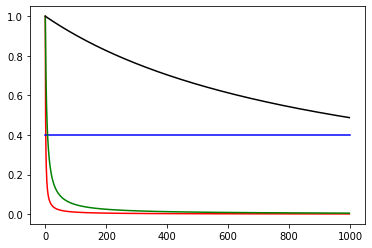

In [7]:
steps_n = []
steps_decl1 = []
steps_decl2 = []
for i in range(1,1000):
  steps_n.append(step_n(i,1))
  steps_decl1.append(step_decl(i,5))
  steps_decl2.append(step_decl(i,950))
plt.plot(steps_n,"red")
plt.plot(np.repeat(0.4,1000),"blue")
plt.plot(steps_decl1,"green")
plt.plot(steps_decl2,"black")
plt.show()

# 3. Model

The next step is to implement our model. For the model we will use a simple lookup table, because we have discrete states and in total just 11 individual states, which we need to evaluate (we are not interested in evaluating the state that we have sold the asset). We will implement the adp-algorithm of slide 17 in lecture 4 for post-decision states (see remarks on slide 47). To simplify the computation we will use the post-decision state for our value evaluation. Note also that we have here a maximization problem and not a minimization problem.

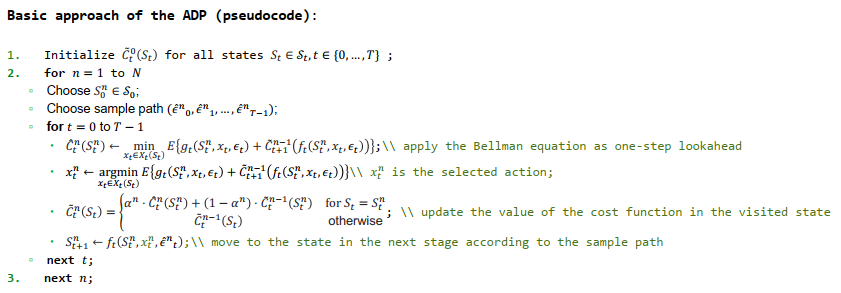

In [8]:
class model():
  """
  Solves our problem instance with aproximate dynamic programming and creates a model to predict our value-function
  
  Args:
      T: The maximum stages of our problem-instance
      stepsize_func (otpional): The function for our learning rate
      c (optional): Constant for our learning rate function
      model (optional): The model used for prediction. If nothing is given, a new one will initialized
  """

  def __init__(self,T,stepsize_func=step_n,c=1,model=None,asset=None):
    self.model = np.zeros((T))
    self.T = T
    if model is not None:
        self.model = model
    self.expected_rewards = []
    self.asset = asset_simulation(T)
    self.stepsize_func = stepsize_func
    self.c = c

  def get_model(self):
    return self.model
  
  def evaluate(self,iterations):
    """
    Runs samples and evaluates the Bellman equation

    Args:
        iterations: number of samples
    
    Returns:
        Sampled rewards
    """
    rewards = []
    for n in range(1,iterations):
      state,done = self.asset.reset()
      cost = 0
      while not done:
        t = self.asset.get_stage()
        if t<self.T-1:
          action = np.argmax([self.model[t+1],self.asset.get_price()])
        else:
          action = 1
        next_state,reward,done = self.asset.step(action)
        cost += reward
        state = next_state
      rewards.append(cost)
    return rewards

  def train(self, iterations):
    """
    Trains our model and updates our lookup table with each step.

    Args:
        iterations: number of training iterations
    
    Returns:
        Averaged expected sample rewards per iteration
    """
    #add the untrained model to the list of average expected sampled rewards
    self.expected_rewards.append(np.average(self.evaluate(100)))
    for n in range(1,iterations):
      alpha = self.stepsize_func(n,self.c)
      state,done = self.asset.reset()
      cost = 0
      while not done:
          t = self.asset.get_stage()
          if t<self.T-1:
            #evaluate hold or sell via the Bellman equation
            action = np.argmax([0+self.model[t+1],self.asset.get_price()+0])
          else:
            action = 1
          v_max = [self.model[t+1],self.asset.get_price()][action]
          self.model[t] = (1-alpha)*self.model[t]+alpha*v_max
          next_state,reward,done = self.asset.step(action)
          cost += reward
          state = next_state

      self.expected_rewards.append(np.average(self.evaluate(100)))
      if n%100 == 0:
        print('\r',f"iteration {n}, running average reward: {np.average(self.expected_rewards[-10:])}",end="",flush=True)
    print()    
    
    return self.expected_rewards
      

# 4. Train your model

Now it is time to train your model. Plot the expected reward over the training time.

In [9]:
model1 = model(10,stepsize_func=step_cnst,c=5)
reward1 = model1.train(5000)
model2 = model(10,stepsize_func=step_decl,c=950)
reward2 = model2.train(5000)
model3 = model(10,stepsize_func=step_n)
reward3 = model3.train(5000)
model4 = model(10,stepsize_func=step_decl,c=5)
reward4 = model4.train(5000)

 iteration 4900, running average reward: 8.812121212121214
 iteration 4900, running average reward: 8.83939393939394
 iteration 4900, running average reward: 6.223232323232323
 iteration 4900, running average reward: 7.443434343434345


Display the trained value table:

In [10]:
model1.get_model()

array([9.01134934, 8.75435506, 8.67884645, 7.9522199 , 7.78902901,
       7.45111411, 6.99270275, 6.41886806, 3.54772593, 0.        ])

To plot the rewards over the training iterations we will use the following helper function:

In [11]:
def plot_rewards(rewards,optimal_value=1):
  """
  Plots our reward over the training iterations
  
  Args:
    rewards: List of lists, which consists of sampled rewards
    optimal_value (optional): If we know the optimal value we can transform our rewards into an percentage, which indicates how far away we are from the optimal values
  """
  num = 1
  models = ["Model 1"]
  for res in rewards:
    if optimal_value >1:
      res = res/optimal_value
    plt.plot(res,alpha=0.7)
    num += 1
    models.append(f"Model {num}")
  plt.ylabel("Reward [€]")
  plt.xlabel("Iteration [n]")
  plt.legend(models)
  plt.show()

And plot the results. Simply put all your rewards into a list and put it into the helper function:

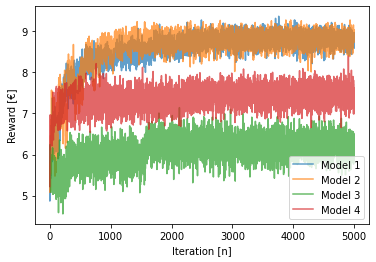

In [12]:
plot_rewards([reward1,reward2,reward3,reward4])

# 5. Compare the results
To evaluate which models are the best, we will run an evaluation of the trained models with fixed policies. For signigicant results, it is always a good practice to compute as many samples as possible.

In [13]:
eval1 = model1.evaluate(100000)
eval2 = model2.evaluate(100000)
eval3 = model3.evaluate(100000)

We will also compare our models with an untrained model. We do so simply by not training a model and run an evaluation. Model 4 becomes now the baseline model!

In [15]:
baseline = model(10,stepsize_func=step_cnst,model=np.repeat(-1,10))
eval_baseline = baseline.evaluate(100000)

To compare the statistics and plot the histograms we will use the following helper functions:

In [16]:
def plot_hists(rewards,optimal_value=1):
  """
  Plots our reward histogram over the sampled rewards
  
  Args:
    rewards: List of lists, which consists of sampled rewards
    optimal_value (optional): If we know the expected optimal value we can transform our rewards into an percentage, which indicates how far away we are from the optimal values
  """
  models = []
  for num in range(1,len(rewards)+1):
    models.append(f"Model {num}")
  plt.hist(rewards,bins=11,label=models)
  plt.xlabel("Exptected Reward [€]")
  plt.ylabel("Amount [n]")
  plt.legend(prop={'size': 10})
  plt.show()

In [17]:
def print_summary(rewards,optimal_value=1):
  """
  Prints the mean and standard deviation of our sampled rewards
  
  Args:
    rewards: List of lists, which consists of sampled rewards
    optimal_value (optional): If we know the optimal value we can transform our rewards into a percentage (gap), which indicates how far away we are from the optimal values
  """
  num = 1
  for res in rewards:
    if optimal_value >1:
      print(f"model {num}: average reward = {np.average(res):.4f}, standard deviation = {np.std(res):.4f}, optimality gap = {np.average(res)/optimal_value*100:.4f}%")
    else:
      print(f"model {num}: average reward = {np.average(res):.4f}, standard deviation = {np.std(res):.4f}")
    num += 1

And we can display the comparison:

model 1: average reward = 8.8094, standard deviation = 1.4583
model 2: average reward = 8.8198, standard deviation = 1.6459
model 3: average reward = 6.2242, standard deviation = 2.4975
model 4: average reward = 4.9880, standard deviation = 3.1583


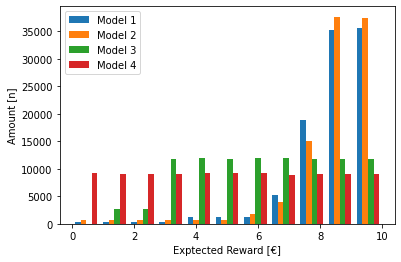

In [18]:
print_summary([eval1,eval2,eval3,eval_baseline])
plot_hists([eval1,eval2,eval3,eval_baseline])

SMALL DISCLAIMER!
During the exercise session we did not get an uniform distribution for the baseline policy, because we always hold at p==0, instead of an random action. Therefore it would be better to adapt the code of the evaluation by either providing some initial values of the model <0 or by providing an explicit random_evaluation() function.

# 6. Compare with the optimal policy
For this problem instance we can actually compute the optimal value function (see the previous sub exercise in the assignment sheet). With this information we can actually calculate how far away of our models are from the optimal value function, by evaluating the performance of the optimal policy.

In [19]:
optimal_policy = [8.835188727,8.687452889,8.506886864,8.286195056,8.016460624,7.647633358,7.140495868,6.363636364,5,0]
optimal_model = model(10,model=optimal_policy)
reward_opt = optimal_model.evaluate(100000)

In [20]:
opt_average = np.average((reward_opt))
opt_average

8.835778357783578

Now we can compare this value with our trained models.

model 1: average reward = 8.8094, standard deviation = 1.4583, optimality gap = 99.7017%
model 2: average reward = 8.8198, standard deviation = 1.6459, optimality gap = 99.8191%
model 3: average reward = 6.2242, standard deviation = 2.4975, optimality gap = 70.4433%
model 4: average reward = 4.9880, standard deviation = 3.1583, optimality gap = 56.4524%
model 5: average reward = 8.8358, standard deviation = 1.6958, optimality gap = 100.0000%


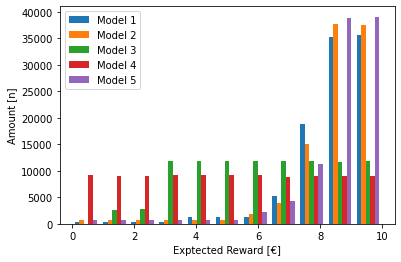

In [22]:
print_summary([eval1,eval2,eval3,eval_baseline,reward_opt],opt_average)
plot_hists([eval1,eval2,eval3,eval_baseline,reward_opt])